In [1]:
!pwd

/data/fetalai


In [21]:
from fastai.vision.all import *
import fastcore.all as fc


In [22]:
# Define the root directory for the dataset
dataroot_dir = Path('dataset')

# Define labeled and unlabeled directories based on dataroot
labeled_dataroot_dir = dataroot_dir/'labeled_data'
unlabeled_dataroot_dir = dataroot_dir/'unlabeled_data'

In [23]:
dataroot_dir.ls(), labeled_dataroot_dir.ls(), unlabeled_dataroot_dir.ls()

((#4) [Path('dataset/Data-sharing Agreement_FUGC2025.docx'),Path('dataset/.ipynb_checkpoints'),Path('dataset/labeled_data'),Path('dataset/unlabeled_data')],
 (#3) [Path('dataset/labeled_data/images'),Path('dataset/labeled_data/.ipynb_checkpoints'),Path('dataset/labeled_data/labels')],
 (#3) [Path('dataset/unlabeled_data/images'),Path('dataset/unlabeled_data/.ipynb_checkpoints'),Path('dataset/unlabeled_data/labels')])

In [24]:
# Define class codes for segmentation
class_codes = ['background', 'anterior', 'posterior']  # Ensure correct class mappings

# Image and mask transformations
item_tfms = [Resize((256, 256), method='nearest')]  # Resize masks with nearest neighbor
batch_tfms = [IntToFloatTensor(), Normalize.from_stats(*imagenet_stats)]

# Function to get the mask path from the image path
def get_y(image_path):
    return Path(str(image_path).replace("images", "labels"))

In [25]:
# Labeled DataBlock (Multi-class Segmentation)
labeled_block = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=class_codes)),  # Multi-class segmentation
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=get_y,  # Map image path to corresponding mask
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Create labeled DataLoaders
labeled_dls = labeled_block.dataloaders(labeled_dataroot_dir/'images', bs=8, shuffle=True)

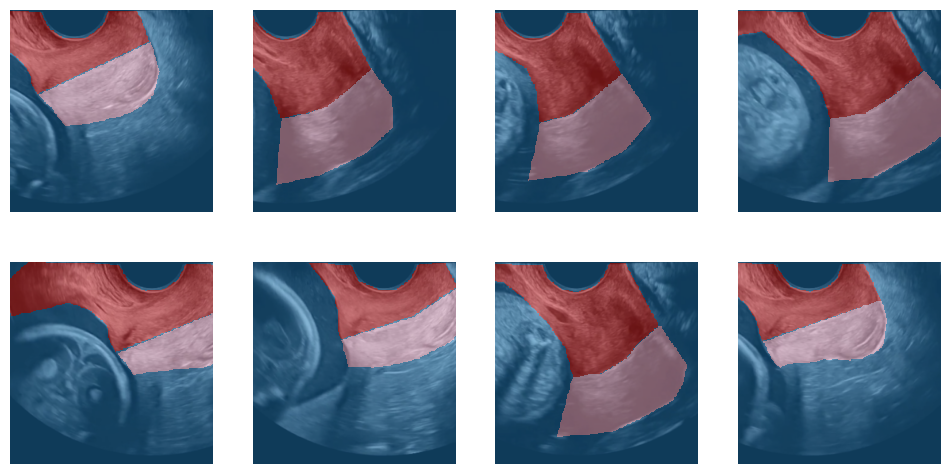

In [26]:
labeled_dls.show_batch()

In [27]:
# Unlabeled DataBlock (for inference)
unlabeled_block = DataBlock(
    blocks=(ImageBlock,),  # Only images, no labels
    get_items=get_image_files,
    splitter=None,  # No splitting needed
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

# Create unlabeled DataLoaders
unlabeled_dls = unlabeled_block.dataloaders(unlabeled_dataroot_dir/'images', bs=8, shuffle=True)

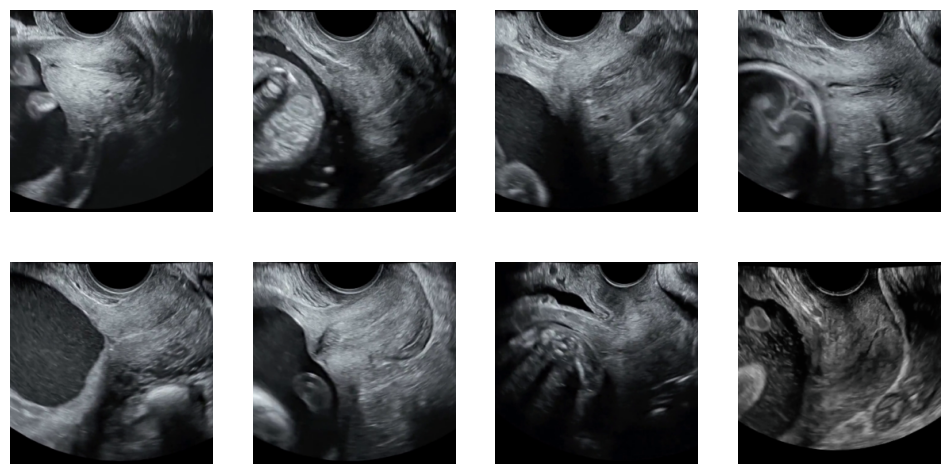

In [28]:
unlabeled_dls.show_batch()

In [38]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)

# %% ../nbs/13_resnet.ipynb 14
def _conv_block(ni, nf, stride, act=act_gr, norm=None, ks=3):
    return nn.Sequential(conv(ni, nf, stride=1, act=act, norm=norm, ks=ks),
                         conv(nf, nf, stride=stride, act=None, norm=norm, ks=ks))

class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1, ks=3, act=act_gr, norm=None):
        super().__init__()
        self.convs = _conv_block(ni, nf, stride, act=act, ks=ks, norm=norm)
        self.idconv = fc.noop if ni==nf else conv(ni, nf, ks=1, stride=1, act=None)
        self.pool = fc.noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)
        self.act = act()

    def forward(self, x): return self.act(self.convs(x) + self.idconv(self.pool(x)))

def up_block(ni, nf, ks=3, act=act_gr, norm=None):
    return nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                         ResBlock(ni, nf, ks=ks, act=act, norm=norm))

class TinyUnet(nn.Module):
    def __init__(self, act=act_gr, nfs=(32,64,128,256,512,1024), norm=nn.BatchNorm2d):
        super().__init__()
        self.start = ResBlock(3, nfs[0], stride=1, act=act, norm=norm)
        self.dn = nn.ModuleList([ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2)
                                 for i in range(len(nfs)-1)])
        self.up = nn.ModuleList([up_block(nfs[i], nfs[i-1], act=act, norm=norm)
                                 for i in range(len(nfs)-1,0,-1)])
        self.up += [ResBlock(nfs[0], 3, act=act, norm=norm)]
        self.end = ResBlock(3, 3, act=nn.Identity, norm=norm)

    def forward(self, x):
        layers = []
        layers.append(x)
        x = self.start(x)
        for l in self.dn:
            layers.append(x)
            x = l(x)
        n = len(layers)
        for i,l in enumerate(self.up):
            if i!=0: x += layers[n-i]
            x = l(x)
        return self.end(x+layers[0])

model = TinyUnet()

# model

In [41]:
def print_model_shapes(model, input_shape=(3, 128, 128)):
    x = torch.randn(1, *input_shape)  # Create a dummy input tensor
    print(f"Input shape: {x.shape}")

    x = model.start(x)
    print(f"After start: {x.shape}")

    layers = []
    for i, l in enumerate(model.dn):
        layers.append(x)
        x = l(x)
        print(f"After dn[{i}]: {x.shape}")

    n = len(layers)
    for i, l in enumerate(model.up):
        if i != 0:
            x += layers[n - i][:, :x.shape[1], :, :]  # Ensure channel match
        x = l(x)
        print(f"After up[{i}]: {x.shape}")

    x = model.end(x + layers[0][:, :x.shape[1], :, :])  # Ensure channel sizes match
    print(f"After end: {x.shape}")

model = TinyUnet()
print_model_shapes(model)

Input shape: torch.Size([1, 3, 128, 128])
After start: torch.Size([1, 32, 128, 128])
After dn[0]: torch.Size([1, 64, 64, 64])
After dn[1]: torch.Size([1, 128, 32, 32])
After dn[2]: torch.Size([1, 256, 16, 16])
After dn[3]: torch.Size([1, 512, 8, 8])
After dn[4]: torch.Size([1, 1024, 4, 4])
After up[0]: torch.Size([1, 512, 8, 8])
After up[1]: torch.Size([1, 256, 16, 16])
After up[2]: torch.Size([1, 128, 32, 32])
After up[3]: torch.Size([1, 64, 64, 64])
After up[4]: torch.Size([1, 32, 128, 128])
After up[5]: torch.Size([1, 3, 128, 128])
After end: torch.Size([1, 3, 128, 128])
